In [1]:
import pandas as pd
import numpy as np
import re # not really used atm
from datetime import datetime
from matplotlib import pyplot as plt
import matplotlib.gridspec as gridspec
import seaborn as sns

In [2]:
from sklearn.preprocessing import StandardScaler # to scale data
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve,roc_auc_score,accuracy_score

# NN model
import keras
from keras.models import Sequential
from keras.models import load_model
from keras.layers import Dense
from keras.optimizers import SGD #test keras


Using TensorFlow backend.


In [3]:
pd.set_option('display.max_rows', 50)
pd.set_option('display.max_columns', 60)
pd.set_option('display.width', None)
pd.set_option('display.max_colwidth', -1)

In [4]:
def check_null(df):
    print('\ncheck null values \n')
    print('shape df: ', df.shape, '\n')
    ok_columns = [col for col in df if df[col].isna().sum() == 0]
    print('ok columns: ', ok_columns, '\n')
    for col in df:
        if df[col].isna().sum() >0:
            print(col, ':', df[col].isna().sum())

In [5]:
df_original = pd.read_csv('../input/output.csv')

In [6]:
df_original.head(3)

,name,flav,truth_match,quark_match,ele_match,PU_frac,jet_pt,jet_eta,n_trk,ValZ0_0,SigZ0_0,ValD0_0,SigZ0_0.1,IP3D_trk_pb_0,IP3D_trk_pu_0,IP3D_trk_pc_0,pt_trk_0,has_time_0,time_0,nhits_0,has_time_truth_0,time_truth_0,nhits_truth_0,ValZ0_1,SigZ0_1,ValD0_1,SigZ0_1.1,IP3D_trk_pb_1,IP3D_trk_pu_1,IP3D_trk_pc_1,...,ValZ0_24,SigZ0_24,ValD0_24,SigZ0_24.1,IP3D_trk_pb_24,IP3D_trk_pu_24,IP3D_trk_pc_24,pt_trk_24,has_time_24,time_24,nhits_24,has_time_truth_24,time_truth_24,nhits_truth_24,IP3Dw,SV1w,JFw,JFCombNNw,Mv2w,Mv1w,IP3DPlusSV1w,has_t0,t0,sigma_t0,has_t0_alex,t0_alex,sigma_t0_alex,has_t0_alex_truth,t0_alex_truth,sigma_t0_alex_truth
0,chiara,5,1,1,0,0,83.3035,2.79517,5,0.462290,39.74930,0.283950,39.74930,0.772943,0.053444,0.173613,22.9957,1,0.042305,2,1,0.041971,2,-0.218200,-15.05000,-0.107653,-15.05000,0.445546,0.192721,0.361732,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0.0,0,0,0.0,0,0.926481,-21.0,-41.0,0.866808,-0.783198,0.055535,-0.623519,2,0.057853,0,1,0.038451,0.007462,1,0.035560,0.005466
1,chiara,0,1,1,0,0,55.9409,3.60055,6,0.020639,2.95859,0.001131,2.95859,0.310058,0.310187,0.379754,30.3267,1,0.037086,4,1,0.041971,3,0.029095,1.69636,0.010696,1.69636,0.227965,0.408232,0.363803,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0.0,0,0,0.0,0,-0.836526,-21.0,-41.0,-4.237590,-0.950782,0.055535,-2.386530,2,0.057853,0,1,0.038451,0.007462,1,0.035560,0.005466
2,chiara,0,0,0,0,0.295327,30.5247,3.95126,6,-1.277080,-47.21200,-0.378989,-47.21200,0.422408,0.208915,0.368677,38.9140,1,-0.107696,3,0,-999.000000,-999,-1.410610,-31.18890,-0.046665,-31.18890,0.268466,0.432518,0.299016,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0.0,0,0,0.0,0,-1.131970,-21.0,-41.0,-4.352550,-0.921247,0.055535,-2.681970,2,-0.125010,0,1,-0.047239,0.011068,1,-0.059581,0.011667


In [7]:
# define some useful variables
use_truth = 1
use_t0 = 1
n_trk_used = 10
tagger = 'IP3D_tracks' # d0z0_traks, IP3D_tracks, IP3Dw, SV1w, JFw, JFCombNNw, Mv2w, Mv1w, IP3DPlusSV1w
manipulate_time = 1
train_ITK = 1
eta_th = 2.4 # not used now, just using 2.5


In [8]:
time_str = 'time' # string to read the time of each track
nhits_str = 'nhits'
#t0_variables = ['has_t0','t0','zero'] # my simple t0
#t0_variables = ['has_t0_alex','t0_alex','sigma_t0_alex'] # BDT t0 reco
t0_variables = ['has_t0_alex','t0_alex'] # BDT t0 reco
t0_suffix = '_alex'

if use_truth:
    time_str = 'time_truth' 
    nhits_str = 'nhits_truth'
    # t0_variables = ['has_t0_alex_truth','t0_alex_truth','sigma_t0_alex_truth'] # BDT t0 rec
    t0_variables = ['has_t0_alex_truth','t0_alex_truth'] # BDT t0 rec
    t0_suffix = '_alex_truth'
    
columns_to_use = dict()
columns_to_use['IP3Dw'] = ['IP3Dw']
columns_to_use['SV1w'] = ['SV1w']
columns_to_use['JFw'] = ['JFw']
columns_to_use['JFCombNNw'] = ['JFCombNNw']
columns_to_use['Mv2w'] = ['Mv2w']
columns_to_use['Mv1w'] = ['Mv1w']
columns_to_use['IP3DPlusSV1w'] = ['IP3DPlusSV1w']
columns_to_use['IP3D_tracks'] = [info+'_'+str(i) for i in range(n_trk_used) for info in ["IP3D_trk_pb","IP3D_trk_pu"]]
columns_to_use['d0z0_traks'] = [info+'_'+str(i) for i in range(n_trk_used) for info in ["ValZ0","SigZ0","ValD0","SigZ0"]]
# info currently not used: "IP3D_trk_pc","pt_trk"
info_from_HGTD = [info+'_'+str(i) for i in range(n_trk_used) for info in ["has_"+time_str, time_str,nhits_str]]
if use_t0:
    info_from_HGTD = info_from_HGTD + t0_variables

In [9]:
# remove rows with NaN (originating e.g. from empty lines in input file)
df_original = df_original[df_original['flav'].notna()] 

In [10]:
# check_null(df)

In [11]:
# do not consider PU jets
df = df_original[(df_original['truth_match']>0) & (df_original['quark_match']>0)]
# keep jets with pt>20 GeV, 2.5<eta<4
df = df[(df['jet_pt']>20) & (df['jet_eta']>2.5) & (df['jet_eta']<4)]
#df = df_original[(df_original['ele_match']<1)]
# for the moment I want to focus on b-vs-light --> keep only real light and b, and put target to flav=5
df = df[(df['flav']==0) | (df['flav']==5) ]
df['target'] = (df['flav'] == 5 ).astype(int)

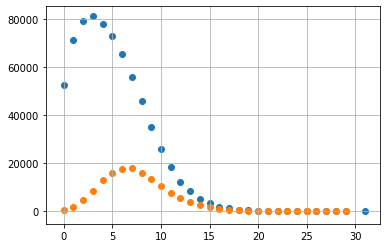

In [12]:
plt.scatter(df_original['n_trk'].value_counts().index, df_original['n_trk'].value_counts())
plt.scatter(df['n_trk'].value_counts().index, df['n_trk'].value_counts())
plt.grid(True)

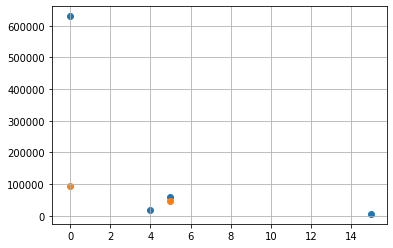

In [13]:
plt.scatter(df_original['flav'].value_counts().index, df_original['flav'].value_counts())
plt.scatter(df['flav'].value_counts().index, df['flav'].value_counts())
plt.grid(True)

In [14]:
# df[['truth_match','quark_match','ele_match']].describe()

In [15]:
# check how many events and the fraction of b-jets
df['target'].describe()

count    141249.000000
mean     0.329142     
std      0.469903     
min      0.000000     
25%      0.000000     
50%      0.000000     
75%      1.000000     
max      1.000000     
Name: target, dtype: float64

In [16]:
df = df.replace([-999],[0])

In [17]:
# change the track pT into fraction of the jet_pt
for i in range(25):
    col = 'pt_trk'+'_'+str(i)
    df[col] = df[col]/df['jet_pt']

In [18]:
# change time into time-t0 (if no t0, t0 is set to zero so no difference)
if manipulate_time:
    df['avg_trk_time'] = 0
    df.loc[df['n_trk']>0,'avg_trk_time'] = (sum(df[time_str+'_'+str(i)] for i in range(25)))/df['n_trk']
    for i in range(25):
        if use_t0:
            col = time_str+'_'+str(i)
            df[col] = df[col]-df['t0'+t0_suffix]
            df.loc[df['has_t0'+t0_suffix]<1, time_str+'_'+str(i)] = df[time_str+'_'+str(i)] - df['avg_trk_time']
        else:
            df[time_str+'_'+str(i)] = df[time_str+'_'+str(i)] - df['avg_trk_time']

In [19]:
#check_null(df)

In [20]:
# df[['flav']+['pt_trk'+'_'+str(i) for i in range(n_trk_used)]].head()
# pfff, these are not pt ordered :( Probably pt-ordeered before calibration

In [21]:
columns_to_use_df = ['target'] + columns_to_use[tagger] + info_from_HGTD
df_to_use = df[columns_to_use_df]

In [22]:
#columns_to_use.remove('target')
# columns_to_use

In [23]:
# convert df into arrays
X = df_to_use[columns_to_use[tagger] + info_from_HGTD].values
y = df_to_use['target'].values
# scaling
sc = StandardScaler()
X = sc.fit_transform(X) 

In [24]:
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size = 0.25)

In [25]:
# Neural network
model = Sequential() # creating model sequentially (each layer takes as input output of previous layer)
model.add(Dense(300, input_dim=len(columns_to_use[tagger]+info_from_HGTD), activation='relu')) # Dense: fully connected layer
# model.add(Dense(50, activation='relu'))
model.add(Dense(1, activation='sigmoid')) # chiara: check what's the best activation function for single-value output
# loss function and optimizer
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['acc'])
# training 
history = model.fit(X_train, y_train, epochs=10, batch_size=32, # it was 100 epochs
                    validation_data = (X_test,y_test)) # show accuracy on test data after every epoch

Train on 105936 samples, validate on 35313 samples
Epoch 1/10
105936/105936 [==============================] - 11s 103us/step - loss: 0.3172 - acc: 0.8750 - val_loss: 0.3071 - val_acc: 0.8783
Epoch 2/10
105936/105936 [==============================] - 11s 102us/step - loss: 0.3090 - acc: 0.8788 - val_loss: 0.3091 - val_acc: 0.8788
Epoch 3/10
105936/105936 [==============================] - 11s 108us/step - loss: 0.3071 - acc: 0.8793 - val_loss: 0.3073 - val_acc: 0.8781
Epoch 4/10
105936/105936 [==============================] - 12s 110us/step - loss: 0.3052 - acc: 0.8805 - val_loss: 0.3066 - val_acc: 0.8781
Epoch 5/10
105936/105936 [==============================] - 11s 108us/step - loss: 0.3044 - acc: 0.8800 - val_loss: 0.3059 - val_acc: 0.8786
Epoch 6/10
105936/105936 [==============================] - 11s 103us/step - loss: 0.3034 - acc: 0.8804 - val_loss: 0.3036 - val_acc: 0.8801
Epoch 7/10
105936/105936 [==============================] - 11s 105us/step - loss: 0.3027 - acc: 0.8810

In [26]:
# Prediction
y_pred_test = model.predict(X_test)
y_pred_train = model.predict(X_train)

fpr_test, tpr_test, thresholds_test = roc_curve(y_test, y_pred_test)
fpr_train, tpr_train, thresholds_train = roc_curve(y_train, y_pred_train)

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: RuntimeWarning: divide by zero encountered in true_divide
  This is separate from the ipykernel package so we can avoid doing imports until
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: divide by zero encountered in true_divide
  after removing the cwd from sys.path.


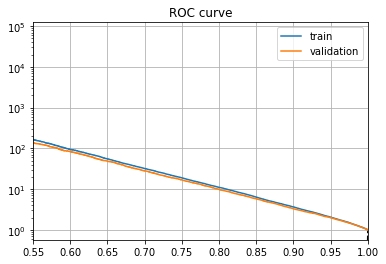

In [27]:
plt.figure(1)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(tpr_train, 1./fpr_train, label='train')
plt.plot(tpr_test, 1./fpr_test, label='validation')
#plt.xlabel('False positive rate')
#plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='best')
plt.yscale('log')
plt.xlim(0.55,1)
plt.grid(True)
plt.show()

In [28]:
type(X_train)

numpy.ndarray

In [29]:
X_train.shape

(105936, 52)

In [30]:
X_train_no_HGTD = X_train[:,0:len(columns_to_use[tagger])]
X_test_no_HGTD = X_test[:,0:len(columns_to_use[tagger])]

In [31]:
X_train_no_HGTD.shape

(105936, 20)

In [32]:
# Neural network
model2 = Sequential() # creating model sequentially (each layer takes as input output of previous layer)
model2.add(Dense(300, input_dim=len(columns_to_use[tagger]), activation='relu')) # Dense: fully connected layer
# model.add(Dense(50, activation='relu'))
# model.add(Dense(20, activation='relu')) 
model2.add(Dense(1, activation='sigmoid')) # chiara: check what's the best activation function for single-value output
model2.compile(loss='binary_crossentropy', optimizer='adam', metrics=['acc'])
# training 
history = model2.fit(X_train_no_HGTD, y_train, epochs=10, batch_size=32, # it was 100 epochs
                    validation_data = (X_test_no_HGTD,y_test)) # show accuracy on test data after every epoch

Train on 105936 samples, validate on 35313 samples
Epoch 1/10
105936/105936 [==============================] - 11s 102us/step - loss: 0.3198 - acc: 0.8732 - val_loss: 0.3124 - val_acc: 0.8773
Epoch 2/10
105936/105936 [==============================] - 10s 97us/step - loss: 0.3141 - acc: 0.8760 - val_loss: 0.3120 - val_acc: 0.8770
Epoch 3/10
105936/105936 [==============================] - 10s 97us/step - loss: 0.3130 - acc: 0.8766 - val_loss: 0.3110 - val_acc: 0.8771
Epoch 4/10
105936/105936 [==============================] - 10s 97us/step - loss: 0.3125 - acc: 0.8765 - val_loss: 0.3138 - val_acc: 0.8770
Epoch 5/10
105936/105936 [==============================] - 11s 100us/step - loss: 0.3120 - acc: 0.8773 - val_loss: 0.3112 - val_acc: 0.8778
Epoch 6/10
105936/105936 [==============================] - 10s 99us/step - loss: 0.3116 - acc: 0.8776 - val_loss: 0.3102 - val_acc: 0.8776
Epoch 7/10
105936/105936 [==============================] - 10s 99us/step - loss: 0.3111 - acc: 0.8782 - va

In [33]:
# Prediction
y_pred_test_no_HGTD = model2.predict(X_test_no_HGTD)
y_pred_train_no_HGTD = model2.predict(X_train_no_HGTD)

fpr_test_no_HGTD, tpr_test_no_HGTD, thresholds_test_no_HGTD = roc_curve(y_test, y_pred_test_no_HGTD)
fpr_train_no_HGTD, tpr_train_no_HGTD, thresholds_train_no_HGTD = roc_curve(y_train, y_pred_train_no_HGTD)

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: divide by zero encountered in true_divide
  from ipykernel import kernelapp as app
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:34: RuntimeWarning: invalid value encountered in true_divide


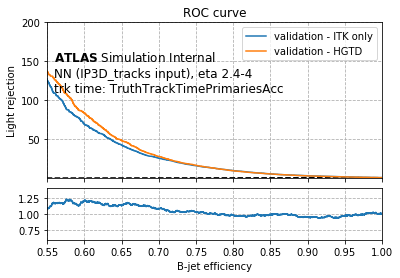

In [34]:
gs = gridspec.GridSpec(2, 1,
                       height_ratios=[3,1],
                       hspace=0.10)
ax1 = plt.subplot(gs[0])

plt.figure(1)
plt.text(0.02, 0.75, r'$\mathbf{ATLAS}$ Simulation Internal', size='large',transform=ax1.transAxes)
plt.text(0.02, 0.65, r'NN ('+tagger+' input), eta 2.4-4', size='large',transform=ax1.transAxes)
if use_truth:
    plt.text(0.02, 0.55, r'trk time: TruthTrackTimePrimariesAcc', size='large',transform=ax1.transAxes)
else:
    plt.text(0.02, 0.55, r'trk time: TrackTimePFTQv05', size='large',transform=ax1.transAxes)
plt.plot([0, 1], [0, 1], 'k--')
#plt.plot(tpr_train_no_HGTD, 1./fpr_train_no_HGTD, label='train_no_HGTD')
one_over_fpr_test_no_HGTD = 1./fpr_test_no_HGTD
one_over_fpr_test = 1./fpr_test
plt.plot(tpr_test_no_HGTD, one_over_fpr_test_no_HGTD, label='validation - ITK only')
#plt.plot(tpr_train, 1./fpr_train, label='train')
plt.plot(tpr_test, one_over_fpr_test, label='validation - HGTD')
plt.ylabel('Light rejection')
plt.title('ROC curve')
plt.legend(loc='best')
#plt.yscale('log')
plt.xlim(0.55,1)
plt.ylim(1,200)
plt.grid(True,linestyle='--')
plt.gca().set_xticklabels(['']*10)

ax2 = plt.subplot(gs[1])
plt.xlim(0.55,1)
plt.ylim(0.6,1.4)
#np.interp([0, 1, 1.5, 2.72, 3.14], xp, fp)
one_over_fpr_test_plot = np.interp(tpr_test_no_HGTD, tpr_test, one_over_fpr_test)
ljr_ratio = np.divide(one_over_fpr_test_plot, one_over_fpr_test_no_HGTD)
plt.plot(tpr_test_no_HGTD, ljr_ratio)
plt.grid(True,linestyle='--')
plt.xlabel('B-jet efficiency')

plt.show()